<a href="https://colab.research.google.com/github/TranNhatMinhTri/CE_Tri23280094/blob/main/BLK_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP & IMPORTS    

In [36]:
# Standard Library Imports
import random
import logging
import os
import sys
import warnings
from typing import Optional, List, Dict, Tuple, Union, Any

# Data Manipulation & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Machine Learning & Preprocessing
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score
)

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

def set_global_seed(seed=42):
    """Cố định toàn bộ random seeds cho reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Đảm bảo TensorFlow chạy deterministic
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    # Tắt GPU nondeterminism (nếu dùng GPU)
    tf.config.experimental.enable_op_determinism()

# --- CẤU HÌNH LOGGING ---
# Xóa cấu hình cũ để tránh trùng lặp trên Colab
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    filename='experiment.log',
    filemode='w', # 'w' để ghi mới mỗi lần chạy lại, 'a' để nối tiếp
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    force=True,
    encoding='utf-8'
)

# Thêm StreamHandler để vẫn in ra màn hình console
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console.setFormatter(formatter)
logging.getLogger('').addHandler(console)

# Khởi tạo logger sau khi cấu hình logging cơ bản
logger = logging.getLogger(__name__)

logger.info("✅ Đã khởi tạo hệ thống Logging thành công.")

# Cấu hình giao diện biểu đồ
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

logger.info(f"✅ Đã nạp xong thư viện. TensorFlow Version: {tf.__version__}")

2025-12-06 02:55:18,785 - INFO - ✅ Đã khởi tạo hệ thống Logging thành công.
2025-12-06 02:55:18,800 - INFO - ✅ Đã nạp xong thư viện. TensorFlow Version: 2.19.0


#STOCK LOADER

In [23]:
class StockLoader:
    """
    Lớp chịu trách nhiệm Tải (Extract) và Làm sạch (Transform) dữ liệu chứng khoán.
    """

    def __init__(self, file_path: str = 'BLK_10Y_daily.csv') -> None:
        self._file_path: str = file_path  # Đổi thành protected
        self._df: Optional[pd.DataFrame] = None

    @property
    def df(self) -> Optional[pd.DataFrame]:
        """Getter để truy cập DataFrame an toàn (Read-only từ bên ngoài)"""
        return self._df

    def upload_file_colab(self) -> bool:
        """Hỗ trợ tải file lên Google Colab."""
        if 'google.colab' not in sys.modules:
            logger.info("Không phải môi trường Colab. Bỏ qua upload.")
            return True

        try:
            from google.colab import files # type: ignore
            logger.info("Đang khởi tạo Upload... Vui lòng chọn file CSV.")
            uploaded = files.upload()

            if not uploaded:
                logger.warning("Người dùng đã hủy tải lên.")
                return False

            self._file_path = next(iter(uploaded))
            logger.info(f"Upload thành công: {self._file_path}")
            return True
        except Exception as e:
            logger.error(f"Upload thất bại: {e}")
            return False

    def load_and_clean(self) -> Optional[pd.DataFrame]:
        """Quy trình ETL chính (Đã chia nhỏ để thỏa mãn rule < 20 dòng)."""
        if not os.path.exists(self._file_path):
            logger.error(f"Không tìm thấy file: {self._file_path}")
            return None

        logger.info(f"Đang đọc dữ liệu từ: {self._file_path}...")
        try:
            self._df = pd.read_csv(self._file_path)

            # Gọi chuỗi các hàm xử lý nhỏ (Chain of Responsibility)
            self._standardize_columns()
            self._process_datetime_index()
            self._handle_missing_and_duplicates()
            self._convert_numeric_types()

            # Final check
            self._df.dropna(subset=['close'], inplace=True)
            if self._df.empty:
                logger.error("Dữ liệu rỗng sau khi xử lý.")
                return None

            logger.info(f"Dữ liệu OK. Shape: {self._df.shape}")
            return self._df

        except Exception as e:
            logger.error(f"Lỗi Load Data: {str(e)}")
            return None

    # --- CÁC PHƯƠNG THỨC NỘI BỘ (PRIVATE METHODS) ---

    def _standardize_columns(self) -> None:
        """Chuẩn hóa tên cột về dạng snake_case."""
        if self._df is not None:
            self._df.columns = [str(col).strip().lower().replace(' ', '_') for col in self._df.columns]

    def _process_datetime_index(self) -> None:
        """Nhận diện và xử lý Index thời gian."""
        if self._df is not None:
            date_col = 'date' if 'date' in self._df.columns else self._df.columns[0]
            if date_col != 'date':
                logger.warning(f"Dùng cột '{date_col}' làm index.")

            self._df[date_col] = pd.to_datetime(self._df[date_col], errors='coerce', format='mixed')
            self._df.set_index(date_col, inplace=True)
            self._df.index.name = 'date'
            self._df.sort_index(ascending=True, inplace=True)

    def _handle_missing_and_duplicates(self) -> None:
        """Xử lý trùng lặp và điền dữ liệu thiếu."""
        if self._df is not None:
            self._df = self._df[~self._df.index.duplicated(keep='first')]
            if self._df.isnull().sum().sum() > 0:
                self._df = self._df.ffill().bfill()

    def _convert_numeric_types(self) -> None:
        """Ép kiểu dữ liệu số."""
        if self._df is not None:
            cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
            for c in cols:
                if c in self._df.columns:
                    self._df[c] = pd.to_numeric(self._df[c], errors='coerce')

#VISUALIZER (EDA)  

In [24]:
class StockVisualizer:
    """
    Module EDA (Exploratory Data Analysis) chuyên biệt cho dữ liệu chứng khoán.
    Nhiệm vụ: Tính toán chỉ báo kỹ thuật và Vẽ biểu đồ phân tích.
    """

    def __init__(self, df: pd.DataFrame) -> None:
        """
        Khởi tạo Visualizer.
        Args:
            df (pd.DataFrame): DataFrame gốc (sẽ được copy để không ảnh hưởng dữ liệu chính).
        """
        self._df: pd.DataFrame = df.copy()
        self._prepare_data()

    @property
    def data(self) -> pd.DataFrame:
        """Getter để truy xuất dữ liệu đã xử lý (Read-only)."""
        return self._df

    def run_eda(self) -> None:
        """Phương thức chính (Facade) để chạy toàn bộ quy trình EDA."""
        logger.info("\n--- BẮT ĐẦU GIAI ĐOẠN PRE-EDA ---")
        self.plot_return_distribution(enable_kde=True)
        self.plot_dual_axis()
        self.plot_correlation()
        self.plot_seasonality() # <--- MỚI THÊM
        logger.info("--- KẾT THÚC PRE-EDA ---\n")

    # ==========================================================================
    # PHẦN 1: TÍNH TOÁN CHỈ SỐ (DATA PREPARATION)
    # ==========================================================================

    def _prepare_data(self) -> None:
        """Điều phối việc tính toán các đặc trưng (Features)."""
        if self._df.empty: return

        self._calc_returns()
        self._calc_rsi()
        self._calc_macd()
        self._add_time_features()
        self._df.dropna(inplace=True)

    def _calc_returns(self) -> None:
        self._df['log_return'] = np.log(self._df['close'] / self._df['close'].shift(1))
        self._df['target'] = self._df['log_return'].shift(-1)

    def _calc_rsi(self, window: int = 14) -> None:
        delta = self._df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        rs = gain / loss
        self._df['rsi'] = 100 - (100 / (1 + rs))

    def _calc_macd(self) -> None:
        ema_12 = self._df['close'].ewm(span=12, adjust=False).mean()
        ema_26 = self._df['close'].ewm(span=26, adjust=False).mean()
        macd = ema_12 - ema_26
        signal = macd.ewm(span=9, adjust=False).mean()
        self._df['macd_hist'] = macd - signal

    def _add_time_features(self) -> None:
        if not isinstance(self._df.index, pd.DatetimeIndex):
            self._df.index = pd.to_datetime(self._df.index)
        self._df['month'] = self._df.index.month
        self._df['day_name'] = self._df.index.day_name()

    # ==========================================================================
    # PHẦN 2: VẼ BIỂU ĐỒ (PLOTTING)
    # ==========================================================================

    def plot_return_distribution(self, enable_kde: bool = True) -> None:
        """Vẽ biểu đồ phân phối lợi suất."""
        if 'log_return' not in self._df.columns: return

        logger.info("   + Vẽ Phân phối Lợi suất...")
        returns = self._df['log_return']

        plt.figure()
        sns.histplot(returns, bins=100, kde=False, stat='density',
                     color='royalblue', alpha=0.4, label='Thực tế (Histogram)')

        if enable_kde:
            sns.kdeplot(returns, color='blue', linewidth=1.5, label='KDE (Mật độ thực tế)')

        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, returns.mean(), returns.std())
        plt.plot(x, p, 'r--', linewidth=2, label='Phân phối chuẩn (Lý thuyết)')

        plt.title('Phân phối Lợi suất Log', fontweight='bold')
        plt.legend()
        plt.show()

    def plot_dual_axis(self) -> None:
        """Vẽ biểu đồ kết hợp: Giá và Khối lượng."""
        logger.info("   + Vẽ Giá và Khối lượng...")
        fig, ax1 = plt.subplots()

        ax1.plot(self._df.index, self._df['close'], color='navy', label='Giá (Price)')
        ax1.set_ylabel('Price', color='navy')
        ax1.grid(True, linestyle='--', alpha=0.5)

        ax2 = ax1.twinx()
        ax2.fill_between(self._df.index, 0, self._df['volume'],
                         color='teal', alpha=0.3, label='Khối lượng (Volume)')
        ax2.set_ylabel('Volume', color='teal')
        ax2.grid(False)

        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

        plt.title('Biểu đồ Giá & Khối lượng', fontweight='bold')
        plt.show()

    def plot_correlation(self) -> None:
        """Vẽ Heatmap tương quan."""
        cols = ['rsi', 'macd_hist', 'target']
        if not all(col in self._df.columns for col in cols): return

        logger.info("   + Vẽ Heatmap Tương quan...")
        plt.figure(figsize=(8, 6))
        sns.heatmap(self._df[cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Tương quan Features vs Target', fontweight='bold')
        plt.show()

    def plot_seasonality(self) -> None:
        """Vẽ biểu đồ hộp Mùa vụ (Seasonal Boxplots)."""
        logger.info("   + Vẽ Biểu đồ Mùa vụ (Seasonality)...")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # 1. Theo Tháng (Month)
        sns.boxplot(
            data=self._df, x='month', y='log_return',
            hue='month', palette='viridis', legend=False, ax=ax1
        )
        ax1.set_title('Phân phối Lợi suất theo Tháng', fontweight='bold')
        ax1.set_xlabel('Tháng')
        ax1.axhline(0, color='red', linestyle='--', alpha=0.7) # Đường hòa vốn

        # 2. Theo Thứ (Day of Week)
        # Sắp xếp thứ tự chuẩn: Thứ 2 -> Thứ 6
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        sns.boxplot(
            data=self._df, x='day_name', y='log_return',
            order=day_order, hue='day_name', palette='magma', legend=False, ax=ax2
        )
        ax2.set_title('Phân phối Lợi suất theo Thứ', fontweight='bold')
        ax2.set_xlabel('Thứ trong tuần')
        ax2.axhline(0, color='red', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

#PIPELINE & SANITY CHECK  

In [25]:
class StockPipeline:
    """
    Quy trình xử lý dữ liệu (ETL Pipeline) chuẩn bị cho Machine Learning.

    Stages:
    1. Anomaly Detection (Xử lý nhiễu)
    2. Feature Engineering (Tạo đặc trưng: Log Return, RSI, MACD...)
    3. Target Creation (Tạo nhãn dự đoán)
    4. Data Splitting (Chia Train/Test)
    5. Scaling (Chuẩn hóa MinMax - CHỈ FEATURES, KHÔNG SCALE TARGET!)
    """

    def __init__(self, df: pd.DataFrame) -> None:
        """
        Args:
            df (pd.DataFrame): Dữ liệu thô đầu vào.
        """
        self._df: pd.DataFrame = df.copy()
        self._scaler: MinMaxScaler = MinMaxScaler(feature_range=(0, 1))

        # Output placeholders
        self._train_data: Optional[pd.DataFrame] = None
        self._test_data: Optional[pd.DataFrame] = None
        self._scaled_train: Optional[pd.DataFrame] = None
        self._scaled_test: Optional[pd.DataFrame] = None

    def run_pipeline(
        self,
        anomaly_threshold: float = 0.15,
        lags: List[int] = [1, 2],
        train_ratio: float = 0.8
    ) -> Tuple[Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[MinMaxScaler]]:
        """
        Thực thi toàn bộ quy trình xử lý dữ liệu.

        Returns:
            Tuple: (X_train_scaled, X_test_scaled, Scaler_object)
        """
        logger.info("--- BẮT ĐẦU PIPELINE XỬ LÝ DỮ LIỆU ---")
        try:
            # 1. Cleaning & Engineering
            self._handle_anomalies(anomaly_threshold)
            self._calc_log_return()

            # Chia nhỏ việc tính toán vector để code gọn gàng
            self._add_moving_averages()
            self._add_bollinger_bands()
            self._add_momentum_indicators() # MACD, RSI
            self._add_volatility()

            self._add_lags(lags)
            self._add_time_features()
            self._create_target()

            # Kiểm tra dữ liệu sau xử lý
            if len(self._df) < 50:
                logger.error("Dữ liệu quá ít sau khi xử lý (dropna).")
                return None, None, None

            # 2. Split & Scale
            self._split_data(train_ratio)
            self._scale_data()

            logger.info("--- PIPELINE HOÀN TẤT ---")
            return self._scaled_train, self._scaled_test, self._scaler

        except Exception as e:
            logger.error(f"PIPELINE ERROR: {e}")
            return None, None, None

    # --- PRIVATE METHODS (DATA PROCESSING) ---

    def _handle_anomalies(self, threshold: float) -> None:
        """Lọc bỏ giá <= 0 và sửa các biến động giá bất thường."""
        # Giá phải dương để tính Log
        self._df = self._df[self._df['close'] > 0]

        # Phát hiện biến động mạnh quá mức cho phép
        mask = self._df['close'].pct_change().abs() > threshold
        if mask.sum() > 0:
            logger.info(f"[PROCESS] Sửa {mask.sum()} điểm giá bất thường (Interpolate).")
            self._df.loc[mask, 'close'] = np.nan
            self._df['close'] = self._df['close'].interpolate(method='time')

            # Đồng bộ các cột giá khác
            for c in ['open', 'high', 'low', 'adj_close']:
                if c in self._df.columns:
                    self._df.loc[mask, c] = self._df.loc[mask, 'close']

    def _calc_log_return(self) -> None:
        """Tính Log Return (Lợi suất liên tục)."""
        self._df['log_return'] = np.log(self._df['close'] / self._df['close'].shift(1))

    def _add_moving_averages(self) -> None:
        """Tính đường trung bình động (SMA)."""
        self._df['sma_20'] = self._df['close'].rolling(20).mean()
        self._df['sma_50'] = self._df['close'].rolling(50).mean()

    def _add_bollinger_bands(self) -> None:
        """Tính dải Bollinger Bands (%B)."""
        std_20 = self._df['close'].rolling(20).std()
        upper = self._df['sma_20'] + (std_20 * 2)
        lower = self._df['sma_20'] - (std_20 * 2)

        # Tránh chia cho 0
        diff = (upper - lower).replace(0, np.nan)
        self._df['bb_percent_b'] = (self._df['close'] - lower) / diff

    def _add_momentum_indicators(self) -> None:
        """Tính MACD và RSI."""
        # MACD
        ema_12 = self._df['close'].ewm(span=12, adjust=False).mean()
        ema_26 = self._df['close'].ewm(span=26, adjust=False).mean()
        macd = ema_12 - ema_26
        signal = macd.ewm(span=9, adjust=False).mean()
        self._df['macd_hist'] = macd - signal

        # RSI
        delta = self._df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        self._df['rsi'] = 100 - (100 / (1 + rs))

    def _add_volatility(self) -> None:
        """Tính độ biến động (Volatility)."""
        self._df['volatility'] = self._df['log_return'].rolling(20).std()

    def _add_lags(self, lags: List[int]) -> None:
        """Tạo các cột trễ (Lag Features)."""
        for lag in lags:
            self._df[f'lag_{lag}'] = self._df['log_return'].shift(lag)

    def _add_time_features(self) -> None:
        """Tách đặc trưng thời gian."""
        if not isinstance(self._df.index, pd.DatetimeIndex):
             self._df.index = pd.to_datetime(self._df.index)

        self._df['quarter'] = self._df.index.quarter
        self._df['month'] = self._df.index.month
        self._df['day_of_week'] = self._df.index.dayofweek

    def _create_target(self) -> None:
        """Tạo Target (Shift -1: Dự báo ngày mai)."""
        self._df['target'] = self._df['log_return'].shift(-1)
        self._df.dropna(inplace=True)

    def _split_data(self, ratio: float) -> None:
        """Chia dữ liệu Train/Test theo thời gian (Không Shuffle)."""
        train_size = int(len(self._df) * ratio)
        self._train_data = self._df.iloc[:train_size]
        self._test_data = self._df.iloc[train_size:]
        logger.info(f"[SPLIT] Train: {len(self._train_data)} | Test: {len(self._test_data)}")

    def _scale_data(self) -> None:
        """
        ✅ SỬA LỖI: Chỉ chuẩn hóa FEATURES, KHÔNG scale TARGET!
        Target (log returns) phải giữ nguyên giá trị gốc để backtest đúng.
        """
        # ✅ QUAN TRỌNG: Danh sách chỉ chứa FEATURES, KHÔNG có 'target'
        feature_cols = [
            'log_return', 'lag_1', 'lag_2', 'rsi', 'macd_hist', 'bb_percent_b',
            'volatility', 'sma_20', 'sma_50', 'quarter', 'month', 'day_of_week'
        ]

        # Chỉ lấy các cột thực sự tồn tại
        if self._train_data is not None:
            existing_features = [c for c in feature_cols if c in self._train_data.columns]

            logger.info(f"[SCALING] Đang scale {len(existing_features)} features (KHÔNG scale target)")

            # Fit Scaler trên tập Train (CHỈ FEATURES)
            self._scaler.fit(self._train_data[existing_features])

            # Transform features
            scaled_train_features = self._scaler.transform(self._train_data[existing_features])

            # ✅ Tạo DataFrame với features đã scale
            self._scaled_train = pd.DataFrame(
                scaled_train_features,
                columns=existing_features,
                index=self._train_data.index
            )

            # ✅ THÊM TARGET GỐC (KHÔNG SCALE) vào DataFrame
            self._scaled_train['target'] = self._train_data['target'].values

            # Transform test set
            if self._test_data is not None:
                scaled_test_features = self._scaler.transform(self._test_data[existing_features])

                self._scaled_test = pd.DataFrame(
                    scaled_test_features,
                    columns=existing_features,
                    index=self._test_data.index
                )

                # ✅ THÊM TARGET GỐC (KHÔNG SCALE) vào DataFrame
                self._scaled_test['target'] = self._test_data['target'].values

            # ✅ Validation: Kiểm tra target có đúng range không
            logger.info(f"[VALIDATION] Target train range: [{self._scaled_train['target'].min():.4f}, {self._scaled_train['target'].max():.4f}]")
            logger.info(f"[VALIDATION] Target test range: [{self._scaled_test['target'].min():.4f}, {self._scaled_test['target'].max():.4f}]")

            # Cảnh báo nếu target có giá trị bất thường
            if abs(self._scaled_train['target'].mean()) > 0.01:
                logger.warning("⚠️  Target mean khá lớn, kiểm tra lại công thức tính log_return!")

            if self._scaled_train['target'].abs().max() > 0.5:
                logger.warning("⚠️  Target có giá trị cực đoan (>0.5), có thể có outliers!")


class PostProcessingEDA:
    """
    Kiểm tra chất lượng dữ liệu SAU khi đã xử lý (Sanity Check).
    """
    def __init__(self, X_train: pd.DataFrame, X_test: pd.DataFrame) -> None:
        self.X_train = X_train
        self.X_test = X_test

    def run_all_checks(self) -> None:
        """Chạy bộ kiểm tra: Scaling Integrity & Data Leakage."""
        logger.info("\n--- BẮT ĐẦU POST-EDA CHECK ---")

        # 1. Kiểm tra Scaling (Biên độ dữ liệu)
        stats = self.X_train.describe().loc[['min', 'max']].T
        # Cho phép sai số nhỏ do làm tròn (-0.01 đến 1.01)
        out_of_bound = ((stats['min'] < -0.01) | (stats['max'] > 1.01)).sum()

        if out_of_bound == 0:
            logger.info("✅ Scaling: PASS (Dữ liệu nằm trong [0, 1]).")
        else:
            logger.error(f"❌ Scaling: FAIL (Có {out_of_bound} cột vượt biên độ).")

        # 2. Kiểm tra Data Leakage (Thời gian)
        if self.X_train.index.max() < self.X_test.index.min():
            logger.info("✅ Data Split: PASS (Không chồng lấn thời gian).")
        else:
            logger.error("❌ Data Split: FAIL (Phát hiện rò rỉ dữ liệu tương lai!).")

#MODEL BUILDER  

In [26]:
class StockModelBuilder:
    """
    Quản lý việc Xây dựng (Build) và Huấn luyện (Train) đa mô hình.
    Hỗ trợ: LSTM (Deep Learning), XGBoost, Random Forest.
    """

    def __init__(self) -> None:
        # Encapsulation: Bảo vệ danh sách model
        self._models: Dict[str, Any] = {}

    @property
    def models(self) -> Dict[str, Any]:
        """Getter để truy cập danh sách model (Read-only)."""
        return self._models

    def __repr__(self) -> str:
        """Hiển thị trạng thái class khi print()."""
        return f"<StockModelBuilder: {list(self._models.keys())}>"

    # ==========================================================================
    # PHẦN 1: BUILDER METHODS (XÂY DỰNG MÔ HÌNH)
    # ==========================================================================

    def build_lstm(self, input_shape: Tuple[int, int], units: int = 64,
                   dropout: float = 0.2, lr: float = 0.001) -> None:
        """Khởi tạo kiến trúc mạng LSTM (Keras)."""
        logger.info(f"   + Init LSTM (Input: {input_shape})...")

        model = Sequential()
        model.add(InputLayer(shape=input_shape))
        model.add(LSTM(units=units, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='linear'))

        model.compile(
            loss='mean_squared_error',
            optimizer=Adam(learning_rate=lr)
        )
        self._models['lstm'] = model

    def build_random_forest(self, n_estimators: int = 100) -> None:
        """Khởi tạo Random Forest Regressor."""
        logger.info("   + Init Random Forest...")
        self._models['rf'] = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=10,
            n_jobs=-1,
            random_state=42
        )

    def build_xgboost(self, n_estimators: int = 100) -> None:
        """Khởi tạo XGBoost Regressor."""
        logger.info("   + Init XGBoost...")
        self._models['xgb'] = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=6,
            objective='reg:squarederror',
            n_jobs=-1,
            random_state=42
        )

    # ==========================================================================
    # PHẦN 2: TRAINER METHODS (HUẤN LUYỆN)
    # Chia nhỏ logic train cho từng loại model để code gọn gàng
    # ==========================================================================

    def train_all_models(
        self,
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_val: Optional[pd.DataFrame] = None,
        y_val: Optional[pd.Series] = None
    ) -> None:
        """
        Huấn luyện toàn bộ các model đã được khởi tạo.
        Tự động điều phối dữ liệu vào hàm train tương ứng.
        """
        logger.info("\n--- BẮT ĐẦU HUẤN LUYỆN MODEL ---")

        for name, model in self._models.items():
            logger.info(f"> Đang huấn luyện: {name.upper()}...")

            if name == 'lstm':
                self._train_lstm(model, X_train, y_train, X_val, y_val)
            elif name == 'xgb':
                self._train_xgboost(model, X_train, y_train, X_val, y_val)
            else:
                self._train_generic(model, X_train, y_train)

    def _reshape_3d(self, X: pd.DataFrame) -> np.ndarray:
        """Helper: Chuyển dữ liệu 2D sang 3D cho LSTM [Samples, 1, Features]."""
        vals = X.values if hasattr(X, 'values') else X
        return vals.reshape((vals.shape[0], 1, vals.shape[1]))

    def _train_lstm(self, model: Any, X_train: pd.DataFrame, y_train: pd.Series,
                    X_val: Optional[pd.DataFrame], y_val: Optional[pd.Series]) -> None:
        """Logic huấn luyện riêng cho LSTM (Reshape, Callbacks)."""
        # Chuẩn bị dữ liệu 3D
        X_tr_3d = self._reshape_3d(X_train)
        validation_data = None

        if X_val is not None and y_val is not None:
            validation_data = (self._reshape_3d(X_val), y_val)

        # Cấu hình dừng sớm
        callbacks = []
        if validation_data is not None:
              callbacks.append(
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            )

        model.fit(
            X_tr_3d, y_train,
            validation_data=validation_data,
            epochs=50,
            batch_size=32,
            callbacks=callbacks,
            verbose=0,
            shuffle=False # Quan trọng với Time Series
        )

    def _train_xgboost(self, model: Any, X_train: pd.DataFrame, y_train: pd.Series,
                       X_val: Optional[pd.DataFrame], y_val: Optional[pd.Series]) -> None:
        """Logic huấn luyện riêng cho XGBoost (Eval Set)."""
        eval_set = None
        if X_val is not None and y_val is not None:
            eval_set = [(X_val, y_val)]

        model.fit(
            X_train, y_train,
            eval_set=eval_set,
            verbose=False
        )

    def _train_generic(self, model: Any, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        """Logic huấn luyện cho các model Sklearn (Random Forest)."""
        model.fit(X_train, y_train)

#BACKTESTING ENGINE  

In [27]:
class BacktestingPipeline:
    """
    Hệ thống giả lập giao dịch (Simulation Engine).
    Thực hiện quy trình: Signal -> Execution -> Accounting -> Reporting.
    """

    def __init__(self, initial_capital: float = 10000.0, transaction_cost: float = 0.001) -> None:
        self._initial_capital: float = initial_capital
        self._transaction_cost: float = transaction_cost

    def run_simulation(self, model: Any, X_test, y_test: pd.Series,
                      model_name: str = "AI Model") -> Tuple[pd.DataFrame, float, float]:
        """
        Chạy backtest với model cụ thể.

        Returns:
            Tuple[df_data, final_ai, final_market]
        """
        print(f"\n--- 📊 BACKTESTING: {model_name.upper()} ---")

        # ✅ PREDICT RIÊNG CHO TỪNG MODEL
        X_input = self._prepare_input(X_test, model_name)
        predictions = model.predict(X_input).flatten()

        # Tạo DataFrame
        df_data = pd.DataFrame({
            'actual_return': y_test.values,
            'predicted_return': predictions
        }, index=y_test.index)

        # ✅ SỬ DỤNG PRIVATE METHODS
        df_data = self._generate_signals(df_data)
        df_data = self._calculate_pnl(df_data)
        df_data, final_ai, final_market = self._calculate_equity_curve(df_data)

        # In báo cáo
        self._print_report(final_ai, final_market)

        return df_data, final_ai, final_market

    def _prepare_input(self, X_test, model_name: str):
        """Chuẩn bị input cho từng loại model."""
        if model_name.lower() == 'lstm':
            X_vals = X_test.values if hasattr(X_test, 'values') else X_test
            return X_vals.reshape((X_vals.shape[0], 1, X_vals.shape[1]))
        else:
            return X_test

    def _generate_signals(self, df: pd.DataFrame) -> pd.DataFrame:
        """Tạo tín hiệu Mua/Bán từ dự báo."""
        df['signal'] = np.sign(df['predicted_return'])
        df['signal'] = df['signal'].shift(1).fillna(0)
        return df

    def _calculate_pnl(self, df: pd.DataFrame) -> pd.DataFrame:
        """Tính toán lợi nhuận ròng sau phí."""
        trades = df['signal'].diff().abs()
        gross_return = df['signal'] * df['actual_return']
        cost = trades * self._transaction_cost
        df['strategy_net_return'] = gross_return - cost
        return df

    def _calculate_equity_curve(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, float, float]:
        """Tính giá trị tài sản cộng dồn."""
        df['equity_curve_ai'] = self._initial_capital * np.exp(df['strategy_net_return'].cumsum())
        df['equity_curve_market'] = self._initial_capital * np.exp(df['actual_return'].cumsum())

        final_ai = df['equity_curve_ai'].iloc[-1]
        final_market = df['equity_curve_market'].iloc[-1]
        return df, final_ai, final_market

    def _print_report(self, final_ai: float, final_market: float) -> None:
        """In báo cáo tóm tắt."""
        roi_ai = ((final_ai - self._initial_capital) / self._initial_capital) * 100
        roi_market = ((final_market - self._initial_capital) / self._initial_capital) * 100
        diff = final_ai - final_market

        print(f"   💰 Vốn gốc:      ${self._initial_capital:,.0f}")
        print(f"   📉 Buy & Hold:   ${final_market:,.2f} (ROI: {roi_market:.2f}%)")
        print(f"   📈 AI Strategy:  ${final_ai:,.2f} (ROI: {roi_ai:.2f}%)")

        if final_ai > final_market:
            print(f"   ✅ THÀNH CÔNG (Vượt thị trường +${diff:,.2f})")
        else:
            print(f"   ❌ THẤT BẠI (Thua thị trường -${abs(diff):,.2f})")

    def plot_portfolio_growth(self, df_data: pd.DataFrame, model_name: str) -> None:
        """Vẽ biểu đồ so sánh tăng trưởng tài sản."""
        plt.figure(figsize=(14, 7))

        plt.plot(df_data.index, df_data['equity_curve_market'],
                 label='Buy & Hold', color='gray', linestyle='--', alpha=0.5)

        plt.plot(df_data.index, df_data['equity_curve_ai'],
                 label=f'{model_name} Strategy', color='forestgreen', linewidth=2)

        plt.fill_between(df_data.index, df_data['equity_curve_ai'],
                        alpha=0.1, color='forestgreen')

        final_val = df_data['equity_curve_ai'].iloc[-1]
        last_date = df_data.index[-1]
        plt.scatter(last_date, final_val, color='red', s=100, zorder=5)
        plt.text(last_date, final_val * 1.02, f' ${final_val:,.0f}',
                 color='darkgreen', fontweight='bold')

        plt.title(f'PORTFOLIO VALUE CURVE: {model_name}',
                 fontsize=16, fontweight='bold')
        plt.ylabel('Total Equity ($)')
        plt.legend(loc='upper left')
        plt.show()

#MAIN EXECUTION  

2025-12-06 02:55:47,421 - INFO - >>> KHỞI CHẠY HỆ THỐNG ULTIMA TOÀN DIỆN...
2025-12-06 02:55:47,430 - INFO - Đang đọc dữ liệu từ: BLK_10Y_daily.csv...
2025-12-06 02:55:47,444 - WARNING - Dùng cột 'price' làm index.
2025-12-06 02:55:47,460 - INFO - Dữ liệu OK. Shape: (2516, 5)
2025-12-06 02:55:47,461 - INFO - 
--- ĐANG VẼ BIỂU ĐỒ KHÁM PHÁ (PRE-EDA)...
2025-12-06 02:55:47,473 - INFO - 
--- BẮT ĐẦU GIAI ĐOẠN PRE-EDA ---
2025-12-06 02:55:47,474 - INFO -    + Vẽ Phân phối Lợi suất...


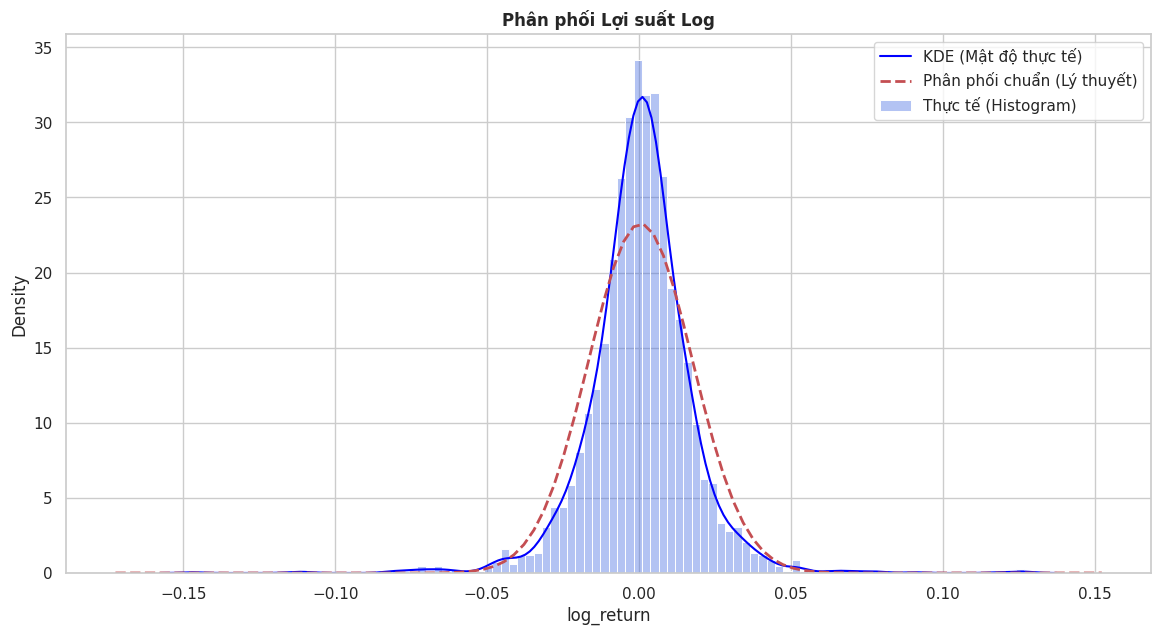

2025-12-06 02:55:47,866 - INFO -    + Vẽ Giá và Khối lượng...


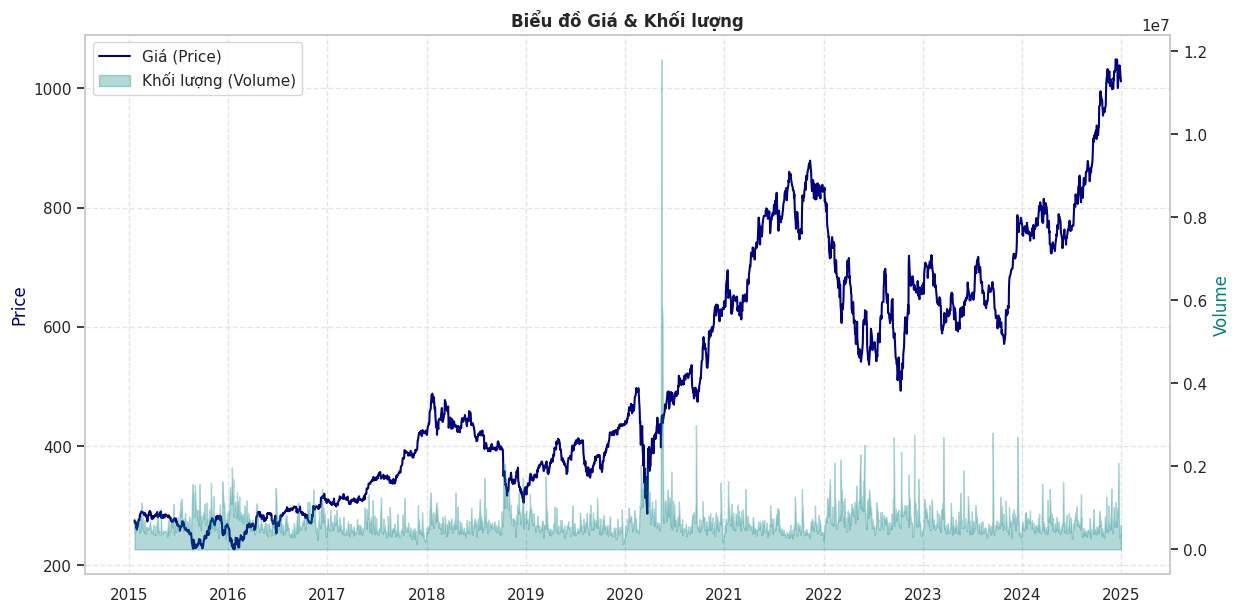

2025-12-06 02:55:48,194 - INFO -    + Vẽ Heatmap Tương quan...


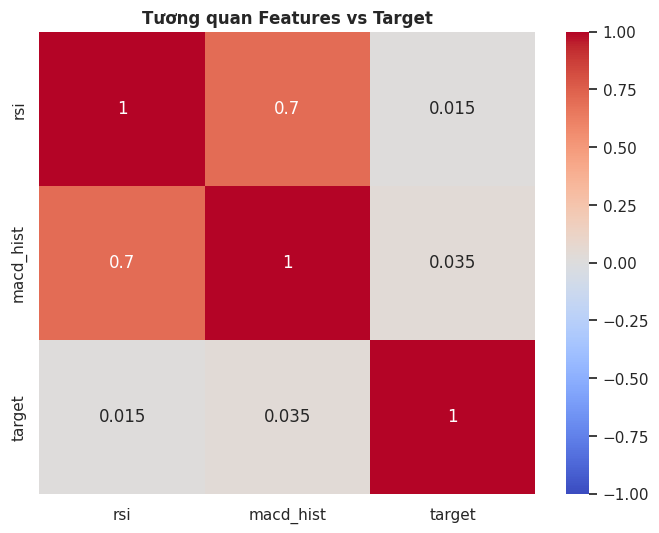

2025-12-06 02:55:48,389 - INFO -    + Vẽ Biểu đồ Mùa vụ (Seasonality)...
2025-12-06 02:55:48,435 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-06 02:55:48,447 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-06 02:55:48,610 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-06 02:55:48,624 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


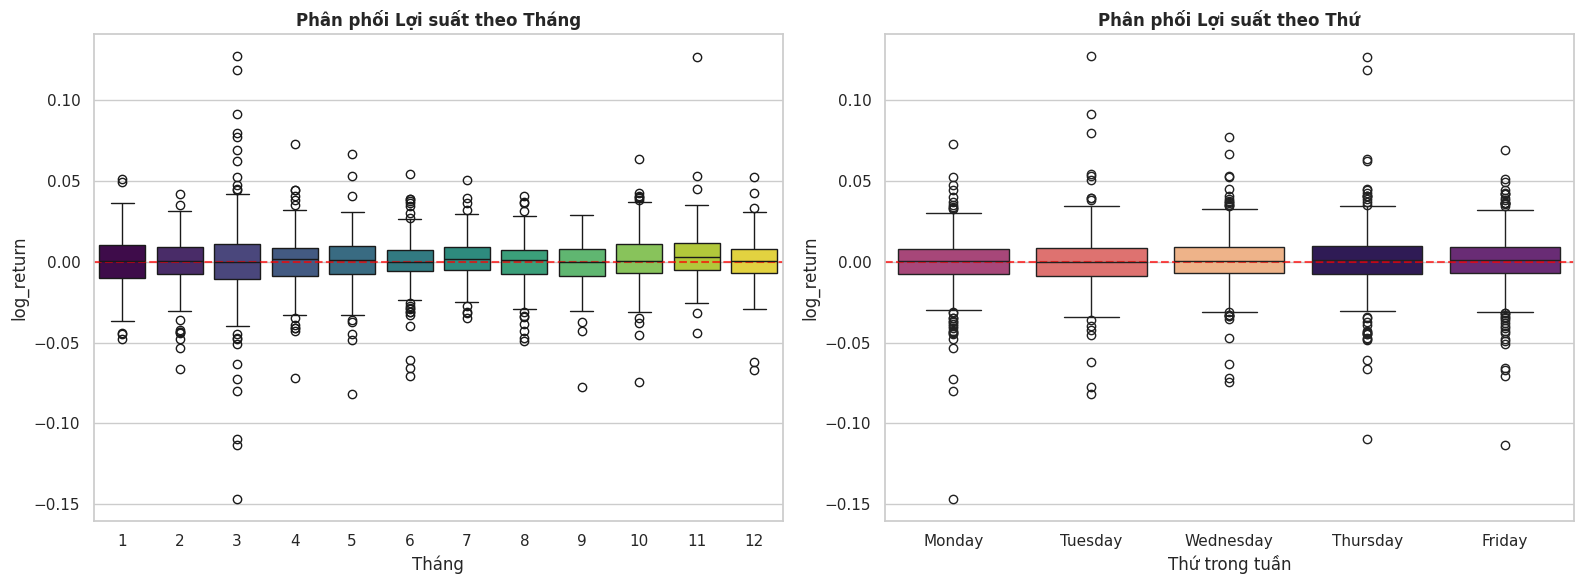

2025-12-06 02:55:48,969 - INFO - --- KẾT THÚC PRE-EDA ---

2025-12-06 02:55:48,972 - INFO - --- BẮT ĐẦU PIPELINE XỬ LÝ DỮ LIỆU ---
2025-12-06 02:55:48,995 - INFO - [SPLIT] Train: 1972 | Test: 494
2025-12-06 02:55:48,996 - INFO - [SCALING] Đang scale 12 features (KHÔNG scale target)
2025-12-06 02:55:49,014 - INFO - [VALIDATION] Target train range: [-0.1468, 0.1268]
2025-12-06 02:55:49,016 - INFO - [VALIDATION] Target test range: [-0.0348, 0.0529]
2025-12-06 02:55:49,018 - INFO - --- PIPELINE HOÀN TẤT ---
2025-12-06 02:55:49,018 - INFO - 
--- BẮT ĐẦU POST-EDA CHECK ---
2025-12-06 02:55:49,049 - ERROR - ❌ Scaling: FAIL (Có 1 cột vượt biên độ).
2025-12-06 02:55:49,050 - INFO - ✅ Data Split: PASS (Không chồng lấn thời gian).
2025-12-06 02:55:49,055 - INFO - 
--- ĐANG VẼ BIỂU ĐỒ KIỂM TRA (POST-EDA)...
2025-12-06 02:55:49,055 - INFO - 
--- BẮT ĐẦU POST-EDA CHECK ---
2025-12-06 02:55:49,081 - INFO - ✅ Scaling: PASS (Dữ liệu nằm trong [0, 1]).
2025-12-06 02:55:49,083 - INFO - ✅ Data Split: PASS


--- 📊 BACKTESTING: LSTM ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
   💰 Vốn gốc:      $10,000
   📉 Buy & Hold:   $14,322.39 (ROI: 43.22%)
   📈 AI Strategy:  $10,119.29 (ROI: 1.19%)
   ❌ THẤT BẠI (Thua thị trường -$4,203.09)


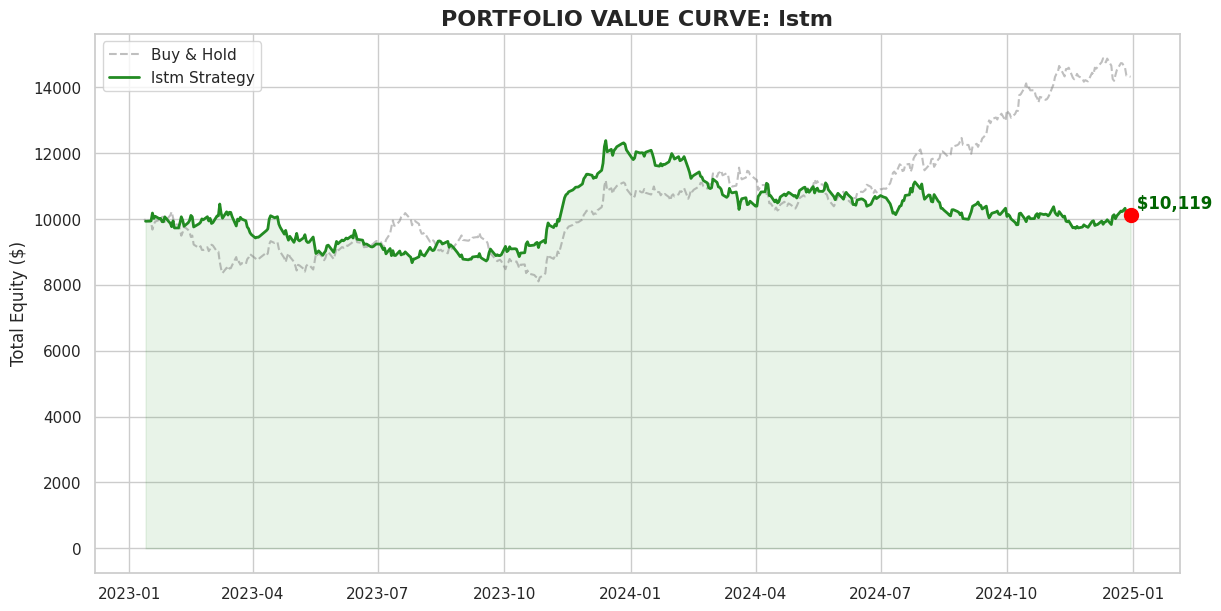

2025-12-06 02:55:58,874 - INFO - 
🔄 Đang backtest model: XGB...



--- 📊 BACKTESTING: XGB ---
   💰 Vốn gốc:      $10,000
   📉 Buy & Hold:   $14,322.39 (ROI: 43.22%)
   📈 AI Strategy:  $6,182.26 (ROI: -38.18%)
   ❌ THẤT BẠI (Thua thị trường -$8,140.13)


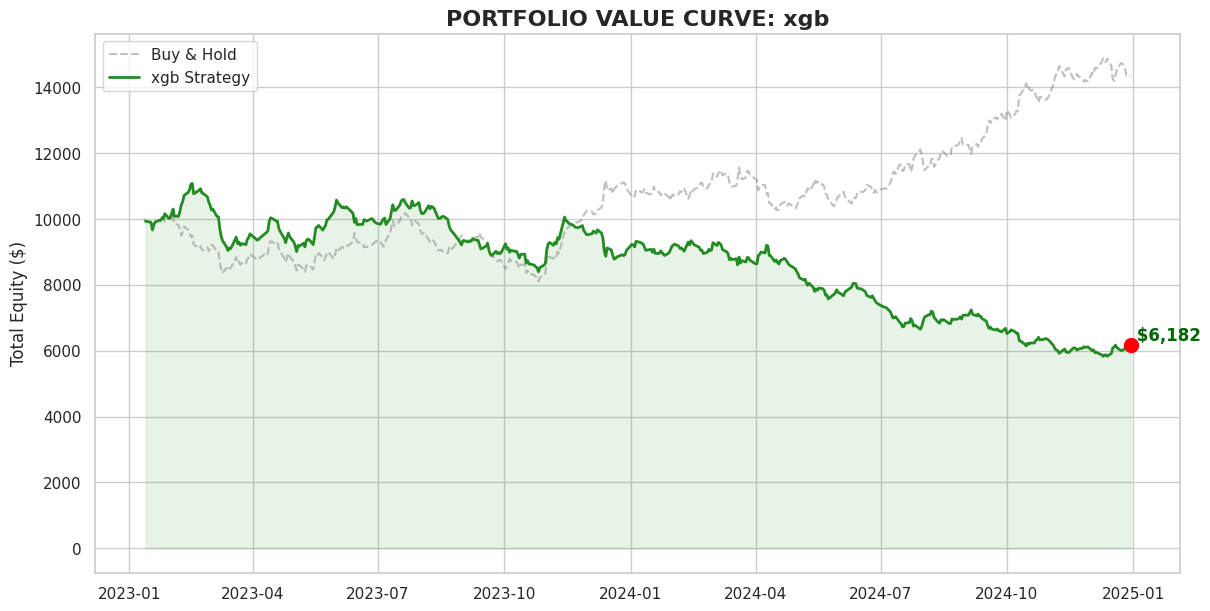

2025-12-06 02:55:59,141 - INFO - 
🔄 Đang backtest model: RF...



--- 📊 BACKTESTING: RF ---
   💰 Vốn gốc:      $10,000
   📉 Buy & Hold:   $14,322.39 (ROI: 43.22%)
   📈 AI Strategy:  $8,030.15 (ROI: -19.70%)
   ❌ THẤT BẠI (Thua thị trường -$6,292.24)


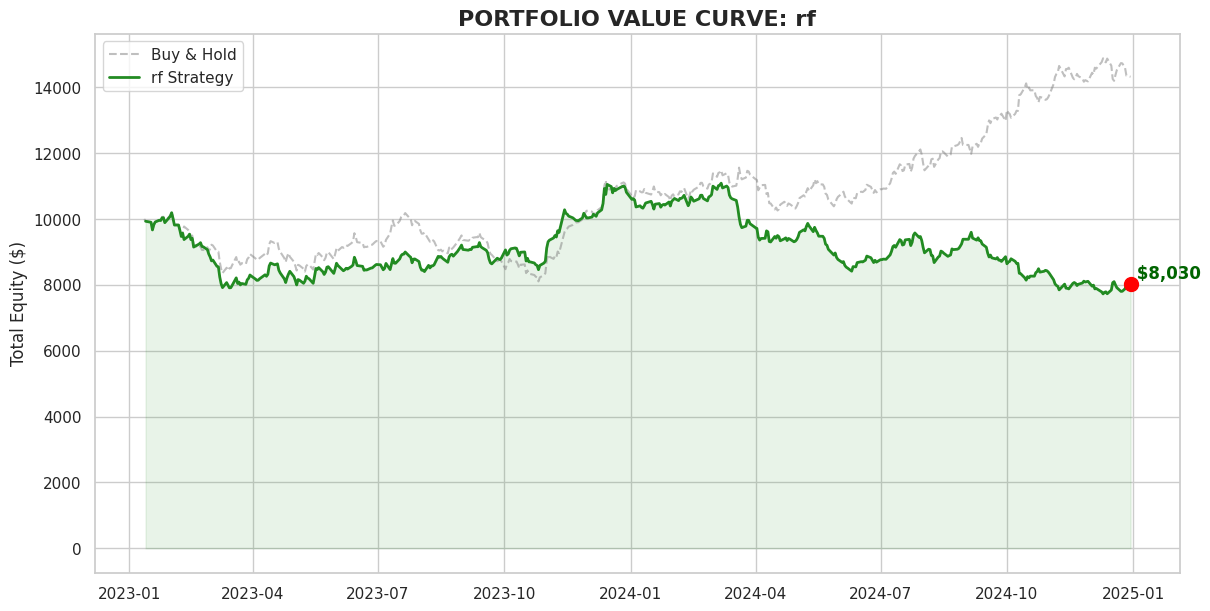

2025-12-06 02:55:59,439 - INFO - 
2025-12-06 02:55:59,441 - INFO - 🏆 TỔNG KẾT XẾP HẠNG CHIẾN LƯỢC
2025-12-06 02:55:59,442 - INFO - ============================================================
2025-12-06 02:55:59,443 - INFO - 1. LSTM     | Profit: $ 10,119.29 | ROI:   1.19% | ❌ THUA LỖ
2025-12-06 02:55:59,445 - INFO - 2. RF       | Profit: $  8,030.15 | ROI: -19.70% | ❌ THUA LỖ
2025-12-06 02:55:59,449 - INFO - 3. XGB      | Profit: $  6,182.26 | ROI: -38.18% | ❌ THUA LỖ
2025-12-06 02:55:59,451 - INFO - ============================================================
2025-12-06 02:55:59,453 - INFO - 
🥇 CHIẾN LƯỢC TỐT NHẤT: LSTM
2025-12-06 02:55:59,454 - INFO -    💰 Lợi nhuận: $10,119.29
2025-12-06 02:55:59,456 - INFO -    📈 ROI: 1.19%
2025-12-06 02:55:59,458 - INFO -    ⚠️  Thua thị trường: -$4,203.09
2025-12-06 02:55:59,459 - INFO - 
✅ CHƯƠNG TRÌNH HOÀN TẤT.


In [38]:
# ==========================================
# CẤU HÌNH CHẠY (USER CONFIGURATION)
# ==========================================
ENABLE_EDA = True           # True: Vẽ biểu đồ khám phá ban đầu
ENABLE_POST_EDA = True      # True: Vẽ biểu đồ kiểm tra sau xử lý
ENABLE_TRAINING = True      # True: Huấn luyện lại Model

def main() -> None:
    set_global_seed(42)
    """
    Hàm điều phối chính (Orchestrator) của hệ thống Ultima.
    Thực hiện tuần tự: Load -> EDA -> Pipeline -> Model -> Backtest.
    """
    logger.info(">>> KHỞI CHẠY HỆ THỐNG ULTIMA TOÀN DIỆN...")

    # GIAI ĐOẠN KHỞI TẠO DỮ LIỆU
    raw_df = _step_load_data()
    if raw_df is None: return

    # PRE-EDA
    if ENABLE_EDA:
        logger.info("\n--- ĐANG VẼ BIỂU ĐỒ KHÁM PHÁ (PRE-EDA)...")
        _step_run_eda(raw_df)
    else:
        logger.info(">>> Đã bỏ qua bước Pre-EDA (ENABLE_EDA = False).")

    # PIPELINE
    data_pack = _step_run_pipeline(raw_df)
    if not data_pack: return

    X_train, y_train, X_test, y_test = data_pack

    # POST-EDA
    if ENABLE_POST_EDA:
        logger.info("\n--- ĐANG VẼ BIỂU ĐỒ KIỂM TRA (POST-EDA)...")
        checker = PostProcessingEDA(X_train, X_test)
        checker.run_all_checks()
    else:
        logger.info(">>> Đã bỏ qua bước Post-EDA (ENABLE_POST_EDA = False).")

    # MODELING
    builder = _step_train_models(X_train, y_train)

    # BACKTESTING
    _step_run_backtest(builder, X_test, y_test)

    logger.info("\n✅ CHƯƠNG TRÌNH HOÀN TẤT.")


# --- CÁC HÀM HỖ TRỢ (HELPER FUNCTIONS) ---

def _step_load_data() -> Optional[pd.DataFrame]:
    """Bước 1: Tải và làm sạch dữ liệu thô."""
    loader = StockLoader()
    if not os.path.exists('BLK_10Y_daily.csv'):
        if not loader.upload_file_colab():
            return None

    return loader.load_and_clean()


def _step_run_eda(df: pd.DataFrame) -> None:
    """Bước 2: Vẽ biểu đồ khám phá."""
    viz = StockVisualizer(df)
    viz.run_eda()


def _step_run_pipeline(df: pd.DataFrame) -> Optional[Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]]:
    """
    Bước 3: Chạy Pipeline và chuẩn bị dữ liệu train/test.

    ✅ THAY ĐỔI: Không cần trả về real_log_returns riêng nữa.
    y_test đã chứa actual returns cần thiết cho backtest.
    """
    pipeline = StockPipeline(df)
    result = pipeline.run_pipeline()

    if result[0] is None:
        return None

    scaled_train, scaled_test, _ = result

    # Sanity Check
    checker = PostProcessingEDA(scaled_train, scaled_test)
    checker.run_all_checks()

    # Tách Features (X) và Target (y)
    target_col = 'target'
    features = [c for c in scaled_train.columns if c != target_col]

    X_train = scaled_train[features]
    y_train = scaled_train[target_col]
    X_test = scaled_test[features]
    y_test = scaled_test[target_col]

    # ✅ QUAN TRỌNG: y_test chính là actual returns cho backtest
    # Nó đã được pipeline xử lý đúng từ log returns gốc

    return X_train, y_train, X_test, y_test


def _step_train_models(X_train: pd.DataFrame, y_train: pd.Series) -> StockModelBuilder:
    """Bước 4: Khởi tạo và huấn luyện đa mô hình."""
    logger.info("\n>>> MODELING PHASE...")

    builder = StockModelBuilder()

    # Khởi tạo kiến trúc
    input_shape = (1, X_train.shape[1])
    builder.build_lstm(input_shape=input_shape)
    builder.build_xgboost()
    builder.build_random_forest()

    # Chia Train/Val cho Early Stopping (90/10)
    split_idx = int(len(X_train) * 0.9)
    X_tr, y_tr = X_train.iloc[:split_idx], y_train.iloc[:split_idx]
    X_val, y_val = X_train.iloc[split_idx:], y_train.iloc[split_idx:]

    # Huấn luyện
    builder.train_all_models(X_tr, y_tr, X_val, y_val)

    logger.info("✅ Đã hoàn tất huấn luyện toàn bộ models.")
    return builder


def _step_run_backtest(builder: StockModelBuilder, X_test: pd.DataFrame, y_test: pd.Series) -> None:
    """
    Bước 5: Giả lập giao dịch và xếp hạng.

    ✅ ĐÃ SỬA: Sử dụng API mới của BacktestingPipeline
    - Truyền (model, X_test, y_test) thay vì DataFrame có sẵn predictions
    - BacktestingPipeline tự predict riêng cho từng model
    """
    logger.info("\n>>> BACKTESTING PHASE...")

    backtester = BacktestingPipeline(initial_capital=10000, transaction_cost=0.001)
    leaderboard = []

    for name, model in builder.models.items():
        logger.info(f"\n🔄 Đang backtest model: {name.upper()}...")

        # ✅ GỌI API MỚI: Truyền model, X_test, y_test
        # BacktestingPipeline sẽ tự:
        # 1. Predict riêng cho model này
        # 2. Tạo DataFrame với actual_return và predicted_return
        # 3. Tính toán signals và equity curve
        df_res, ai_equity, market_equity = backtester.run_simulation(
            model=model,
            X_test=X_test,
            y_test=y_test,
            model_name=name
        )

        # Vẽ biểu đồ
        backtester.plot_portfolio_growth(df_res, model_name=name)

        # Lưu kết quả
        leaderboard.append({
            'model': name,
            'profit': ai_equity,
            'market': market_equity,
            'beat_market': ai_equity > market_equity,
            'roi': ((ai_equity - 10000) / 10000) * 100
        })

    # Tổng kết xếp hạng
    _print_leaderboard(leaderboard)


def _print_leaderboard(leaderboard: List[Dict]) -> None:
    """In bảng xếp hạng các chiến lược."""
    logger.info("\n" + "="*60)
    logger.info("🏆 TỔNG KẾT XẾP HẠNG CHIẾN LƯỢC")
    logger.info("="*60)

    # Sắp xếp theo lợi nhuận
    leaderboard.sort(key=lambda x: x['profit'], reverse=True)

    for i, item in enumerate(leaderboard, 1):
        status = "✅ VƯỢT TRỘI" if item['beat_market'] else "❌ THUA LỖ"
        logger.info(
            f"{i}. {item['model'].upper():8s} | "
            f"Profit: ${item['profit']:>10,.2f} | "
            f"ROI: {item['roi']:>6.2f}% | "
            f"{status}"
        )

    logger.info("="*60)

    # Tìm model tốt nhất
    best = leaderboard[0]
    logger.info(f"\n🥇 CHIẾN LƯỢC TỐT NHẤT: {best['model'].upper()}")
    logger.info(f"   💰 Lợi nhuận: ${best['profit']:,.2f}")
    logger.info(f"   📈 ROI: {best['roi']:.2f}%")

    # So sánh với thị trường
    if best['beat_market']:
        diff = best['profit'] - best['market']
        logger.info(f"   ✨ Vượt thị trường: +${diff:,.2f}")
    else:
        diff = best['market'] - best['profit']
        logger.info(f"   ⚠️  Thua thị trường: -${diff:,.2f}")


# --- ENTRY POINT ---
if __name__ == "__main__":
    main()